# SA-CCR analytical app

This notebook implements an interactive analytical app for SA-CCR analytics in python using Jupyter Notebook and [atoti](https://www.atoti.io).

As a quick reminder, the SA-CCR is a regulatory methodology for computing EAD (Exposure At Default) which is part of the consolidated basel framework. It is already implemented for financial institutions in Europe by the Regulation (EU) 2019/876 (CRR II) and will be applicable from June 2021 and January 2022 in the US. In this post, I will walk you through the calculations as defined in the BCBS 279 document.

In this notebook we'll start by creating an atoti app, then we'll load sample data and implement all the necessary chains for aggregating EAD from trades notionals and attributes and supervisory parameters.

We will be referring to the relevant paragraphs of the Consolidated Basel Framework [CRE52](https://www.bis.org/basel_framework/chapter/CRE/52.htm?inforce=20191215) - see numbers in the square brackets.

## Importing and launching atoti



In [1]:
import atoti as tt

config = tt.config.create_config(metadata_db="./metadata.db")
session = tt.create_session(config=config)
session.url

Welcome to atoti 0.4.3.20200729154535!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


'http://localhost:55428'

## Input data

In the following cell we are creating in-memory datastores, by reading csv files hosted on s3:

- `trades_store` with information on the trades, books, notionals, market values, classified into maturity buckets, risk classes and hedging sets. The time period parameters Mi, Ei, Si and Ti [52.31] are also provided in this file 
- `books_store` linking books and desks
- `counterparties_store` proving counterparty attributes, such as name, rating, sector - for analytical purposes
- `countries_store` enriching the data with geographical attributes
- `desks_store` providing desk information
- `nettingSets_store` providing netting set attributes, for instance, the MPOR, and linking to couterparties
- `products_store` with a product typology
- `supervisoryParameters_store` - values set in section "Supervisory specified parameters" - please see [52.72]

As you can see, in addition to the csv file location, I'm specifying for each data store the key fields and the field types.

In [2]:
trades_store = session.read_csv(
    "s3://data.atoti.io/notebooks/sa-ccr/inverted/trades_preprocessed/trades_preprocessed_2020-01-13.csv",
    keys=["AsOfDate", "TradeId"],
    types={
        "Notional": tt.types.DOUBLE,
        "MarketValue": tt.types.DOUBLE,
        "AsOfDate": tt.types.LOCAL_DATE,
        "Mi": tt.types.LOCAL_DATE,
        "Si": tt.types.LOCAL_DATE,
        "Ti": tt.types.LOCAL_DATE,
        "Ei": tt.types.LOCAL_DATE,
    },
)

books_store = session.read_csv(
    "s3://data.atoti.io/notebooks/sa-ccr/inverted/books/books_2020-01-13.csv",
    keys=["AsOfDate", "BookId"],
)
counterparties_store = session.read_csv(
    "s3://data.atoti.io/notebooks/sa-ccr/inverted/counterparties/counterparties_2020-01-13.csv",
    keys=["AsOfDate", "CounterpartyId"],
)
countries_store = session.read_csv(
    "s3://data.atoti.io/notebooks/sa-ccr/inverted/countries.csv", keys=["Country"]
)
desks_store = session.read_csv(
    "s3://data.atoti.io/notebooks/sa-ccr/inverted/desks/desks_2020-01-13.csv",
    keys=["AsOfDate", "DeskId"],
)
nettingSets_store = session.read_csv(
    "s3://data.atoti.io/notebooks/sa-ccr/inverted/nettingSets/nettingSets_2020-01-13.csv",
    keys=["AsOfDate", "NettingId"],
    types={"MPOR": tt.types.DOUBLE, "Collateral": tt.types.DOUBLE},
)
products_store = session.read_csv(
    "s3://data.atoti.io/notebooks/sa-ccr/inverted/products/products_2020-01-13.csv",
    keys=["ProductId"],
)
supervisoryParameters_store = session.read_csv(
    "s3://data.atoti.io/notebooks/sa-ccr/static/supervisoryParameters.csv",
    keys=["AssetClass", "Subclass"],
)

I'm using the "join" command to link the data between different data stores. If I'm not explicitely defining the mapping, then atoti will link the fields having the same name.

In [3]:
trades_store.join(books_store, mapping={"BookId": "BookId", "AsOfDate": "AsOfDate"})
trades_store.join(
    products_store, mapping={"ProductId": "ProductId", "AsOfDate": "AsOfDate"}
)
trades_store.join(
    nettingSets_store, mapping={"NettingSetId": "NettingId", "AsOfDate": "AsOfDate"}
)
trades_store.join(
    supervisoryParameters_store,
    mapping={"AssetClass": "AssetClass", "SP_subclass": "Subclass"},
)
nettingSets_store.join(
    counterparties_store,
    mapping={"CounterpartyId": "CounterpartyId", "AsOfDate": "AsOfDate"},
)
counterparties_store.join(countries_store, mapping={"CountryOfAddress": "Country"})
books_store.join(desks_store)

As a next step, I'm creating the cube:

In [4]:
# Usually atoti's create_cube command creates .SUM and .MEAN measures automatically from numerical data inputs,
# to prevent that I'm running the comman will the mode = no_measures
cube = session.create_cube(trades_store, "main_cube", mode="no_measures")

Let's display the current data model schema:

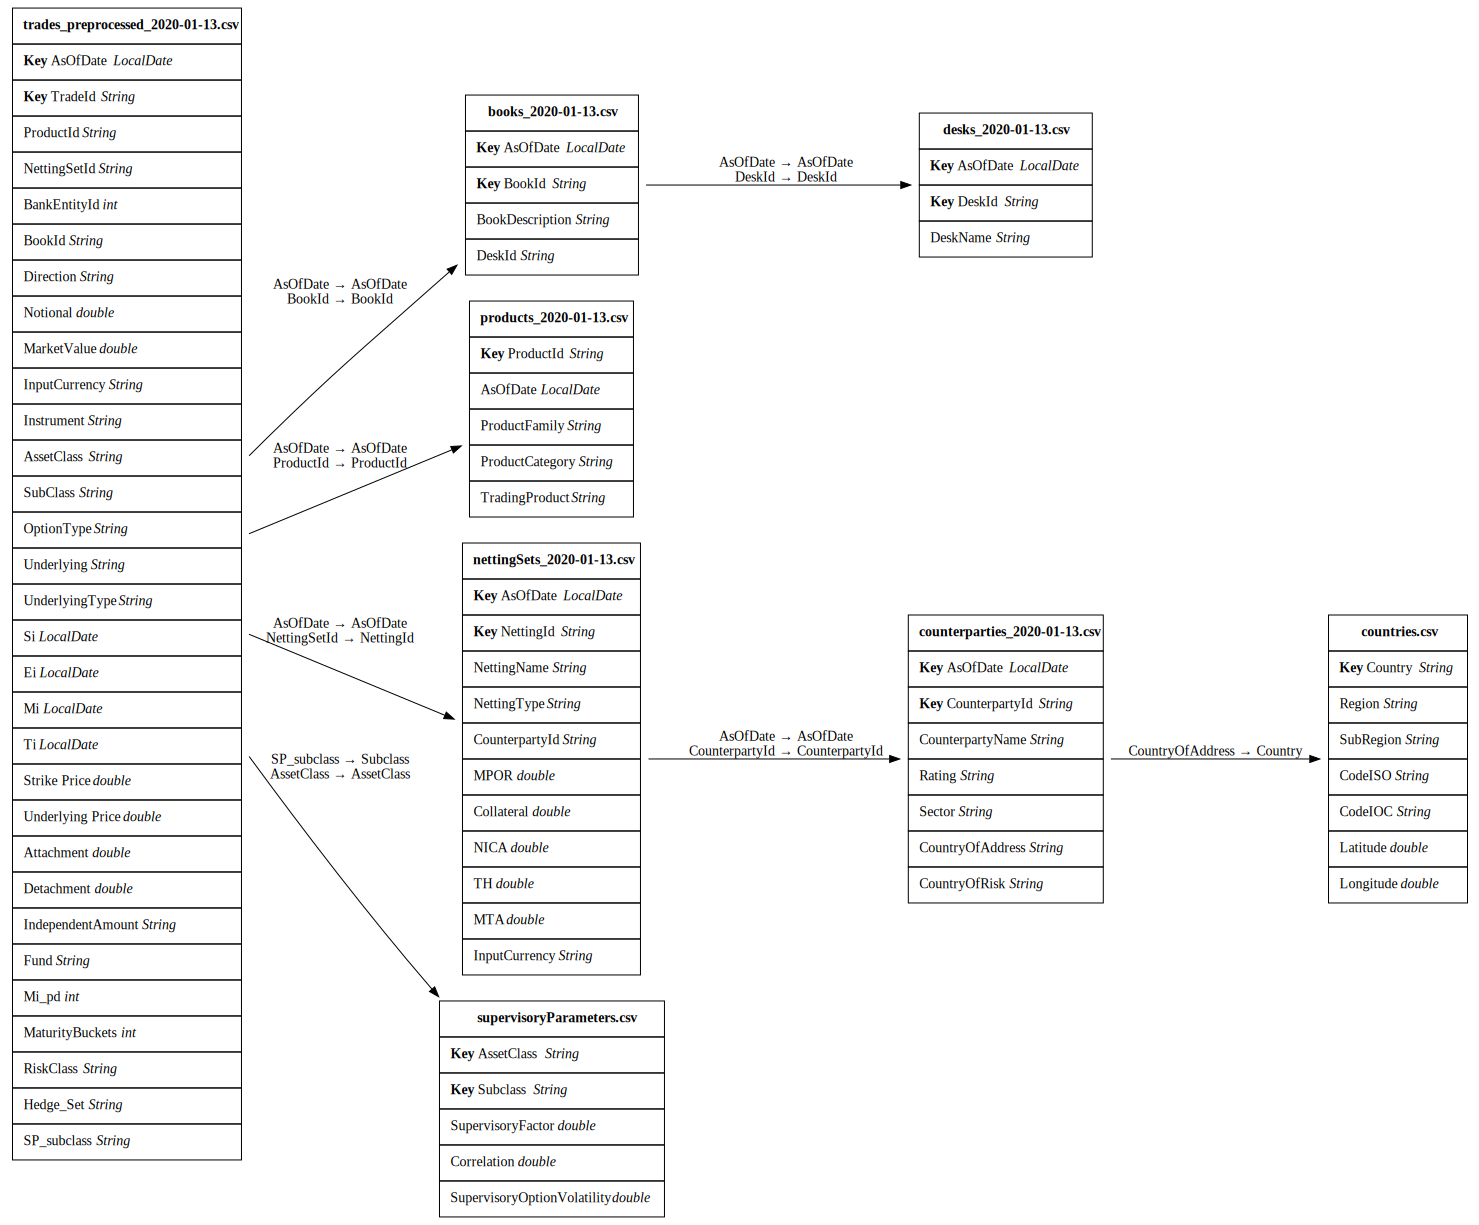

In [5]:
cube.schema

Having the cube created I can view the measures and dimensions and create quick in-line data visualizations using the following command:

In [7]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

But we haven't defined any measures, hence there's not much to analyze yet.

## Aggregation functions for the input data

I can start creating first metrics and refining the cube analytics, by accessing the cube's levels, measures and hierarchies:

In [7]:
lvl = cube.levels
m = cube.measures
h = cube.hierarchies

Now, let's create aggregation functions to visualize the input data: for additive metrics like "Notional" I'm using atoti's `sum` and for measures that are not additive, I'm using `single_value`:

In [8]:
# Trades metrics:
m["Notional"] = tt.agg.sum(trades_store["Notional"])
m["MarketValue"] = tt.agg.sum(trades_store["MarketValue"])
m["Attachment"] = tt.agg.single_value(trades_store["Attachment"])
m["Detachment"] = tt.agg.single_value(trades_store["Detachment"])
m["Underlying Price"] = tt.agg.single_value(trades_store["Underlying Price"])
m["Strike Price"] = tt.agg.single_value(trades_store["Strike Price"])

# Netting sets metrics
m["Collateral.VALUE"] = tt.agg.single_value(nettingSets_store["Collateral"])
m["MPOR.VALUE"] = tt.agg.single_value(nettingSets_store["MPOR"])
m["MTA.VALUE"] = tt.agg.single_value(nettingSets_store["MTA"])
m["NICA.VALUE"] = tt.agg.single_value(nettingSets_store["NICA"])
m["TH.VALUE"] = tt.agg.single_value(nettingSets_store["TH"])

# Supervisory parameters
m["SupervisoryFactor"] = tt.agg.single_value(
    supervisoryParameters_store["SupervisoryFactor"]
)
m["Correlation"] = tt.agg.single_value(supervisoryParameters_store["Correlation"])
m["Supervisory_Option_Volatility"] = tt.agg.single_value(
    supervisoryParameters_store["SupervisoryOptionVolatility"]
)

# Formatting and putting into folders
m["Supervisory_Option_Volatility"].folder = "Trade effective folder"
m["SupervisoryFactor"].formatter = "DOUBLE[#,###.0000]"
m["SupervisoryFactor"].folder = "Technical"
m["Correlation"].folder = "Technical"

In [10]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

## Grouping attributes into folders

I'm grouping the attributes into logical 'folders' so that it's easier to find them in the app:

In [11]:
h["AsOfDate"].dimension = "AsOfDate"

h["AssetClass"].dimension = "AssetClass"
h["SubClass"].dimension = "AssetClass"

h["CounterpartyName"].dimension = "Counterparties"
h["Rating"].dimension = "Counterparties"
h["Sector"].dimension = "Counterparties"

h["CountryOfRisk"].dimension = "Countries"
h["CountryOfAddress"].dimension = "Countries"

h["Direction"].dimension = "Direction"

h["Hedge_Set"].dimension = "Hedge_Set"

h["Instrument"].dimension = "Instrument"

h["MaturityBuckets"].dimension = "MaturityBuckets"

h["NettingName"].dimension = "NettingSets"
h["NettingType"].dimension = "NettingSets"
h["NettingSetId"].dimension = "NettingSets"

h["OptionType"].dimension = "OptionType"

h["ProductId"].dimension = "ProductId"

h["RiskClass"].dimension = "RiskClass"

h["TradeId"].dimension = "TradeId"

h["Ei"].dimension = "TradeAttributes"
h["Mi"].dimension = "TradeAttributes"
h["Si"].dimension = "TradeAttributes"
h["Ti"].dimension = "TradeAttributes"

h["InputCurrency"].dimension = "TradeInputCurrency"

h["Underlying"].dimension = "Underlyings"
h["UnderlyingType"].dimension = "Underlyings"

# Setting up a hierarchy as slicing will prevent aggregations across dates:
h["AsOfDate"].slicing = True
# Comparator will sort the dates:
lvl["AsOfDate"].comparator = tt.comparator.DESC

In [13]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

# SA-CCR calculations

In this section we will create aggregation functions (measures) to compute EAD from the input data described above.

We will proceed bottom-up  - starting with the supervisory duration metric, then move onto the trade-level adjusted notional, maturity factors, delta adjustments, addons and the necessary EAD components. 

We will keep referring to the correponding paragraphs of the [CRE52](https://www.bis.org/basel_framework/chapter/CRE/52.htm?inforce=20191215) as we progress.

## Supervisory duration - [52.34]

In this section we will compute Supervisory Duration per formula defined in CRE52 para [52.34]:

$$SupervisoryDuration = \frac{(exp(-0.05*S_i) - exp(-0.05*E_i))}{0.05}$$ for Credits and Interest Rates and 1 for other Asset Classes. 

In this expression, $S_i$ is based on the start date of trade $i$ and $E_i$ the end date of trade $i$.

In [14]:
number_of_days_in_year = 365.25

In [15]:
# Computing Si and Ei based on the time periods input data and the current date,
# for Interest Rate and Credit Risk classes:
m["s_i_diff"] = tt.filter(
    tt.date_diff(lvl["AsOfDate"], lvl["Si"], unit="days") / number_of_days_in_year,
    lvl["RiskClass"].isin("Interest Rate", "Credit"),
)
m["e_i_diff"] = tt.filter(
    tt.date_diff(lvl["AsOfDate"], lvl["Ei"], unit="days") / number_of_days_in_year,
    lvl["RiskClass"].isin("Interest Rate", "Credit"),
)

# Placing the metrics into the right folder:
m["s_i_diff"].folder = "Trade Effective\\Detail"
m["e_i_diff"].folder = "Trade Effective\\Detail"

# The following code will create a measure allowing us to visualize the supervisory duration
m["Supervisory_Duration"] = tt.where(
    lvl["RiskClass"].isin("Interest Rate", "Credit"),
    (tt.exp(-0.05 * m["s_i_diff"]) - tt.exp(-0.05 * m["e_i_diff"])) / 0.05,
    1.0,
)
m["Supervisory_Duration"].folder = "Trade Effective"

In [17]:
# cube.pivot(measures=[s_i_diff, e_i_diff, SDIR, SDCI, SDCSN, Supervisory_Duration], rows=["AssetClass", "Si", "Ei"], columns="AsOfDate")
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

## Trade-level adjusted notional (for trade i): di - [52.34]

In this step we compute the Adjusted notional. Please review the paragraphs of the CRE52 [52.33] - [52.34] for more information on the defintinions of these formula.

$$AdjustedNotional = Notional * SupervisoryDuration$$

In [18]:
# The generic formula for the Adjusted Notional
# We will later apply it on trade level:
m["Adjusted_Notional"] = tt.agg.sum(
    m["Notional"] * m["Supervisory_Duration"], scope=tt.scope.origin(lvl["AssetClass"])
)
m["Adjusted_Notional"].folder = "Trade Effective"

## Maturity factors - [52.48] - [52.53]

The Maturity Factor takes different values, depending on wether the trade is margined or unmargined:

margined :

$$MF = 1.5 * \sqrt{\frac{MPOR}{1 year}}$$

unmargined :

$$MF = \sqrt{\frac{min(M_i, 1year)}{1year}}$$

The $MPOR$ is the Margin Period Of Risk, provided in the input dataset. $M_i$ is the maturity of trade $i$

In [19]:
# THis measure will compute date difference depending on the value date and the maturity date:
m["m_i_diff"] = tt.date_diff(lvl["AsOfDate"], lvl["Mi"], unit="days")
m["m_i_diff"].folder = "Trade Effective\\Detail"

# This measure will compute maturity factor, depending on wether the trade is margined or unmargined:
m["Maturity_Factor"] = tt.where(
    lvl["NettingType"] == "margined",
    1.5 * tt.sqrt(m["MPOR.VALUE"] / number_of_days_in_year),
    tt.sqrt(min(m["m_i_diff"], number_of_days_in_year) / number_of_days_in_year),
)
m["Maturity_Factor"].folder = "Trade Effective"

## Supervisory delta adjustments - [52.38] - [52.41]

Supervisory Delta takes different values depending on the nature of the instrument: 

| $\delta_i$        | Bought / Long in the primary risk factor                                          | Sold / Short in the primary risk factor                                            |
|-------------------|-----------------------------------------------------------------------------------|----------------------------------------------------------------------------------  |
| Call Options      | $+ \Phi(\frac{ln(P_i / K_i) + 0.5 * \sigma_i^2 * T_i}{\sigma_i * \sqrt{T_i}})$    | $ - \Phi(\frac{ln(P_i / K_i) + 0.5 * \sigma_i^2 * T_i}{\sigma_i * \sqrt{T_i}})$    |
| Put Options       | $- \Phi( - \frac{ln(P_i / K_i) + 0.5 * \sigma_i^2 * T_i}{\sigma_i * \sqrt{T_i}})$ | $ + \Phi( - \frac{ln(P_i / K_i) + 0.5 * \sigma_i^2 * T_i}{\sigma_i * \sqrt{T_i}})$ |
| CDO tranches      | $+ \frac{15}{(1+14*A_i)*(1+14*D_i)}$                                              | $- \frac{15}{(1+14*A_i)*(1+14*D_i)}$                                               |
| Other Instruments | $+1$                                                                              | $-1$                                                                               |

Where $\Phi$ is the Normal distribution function,

$P_i$ is the Underlying Price of trade $i$,

$K_i$ is the Strike Price of trade $i$,

$\sigma_i$ is the Supervisory Volatility of trade $i$,

$T_i$ is the latest contractual exercise date of the option $i$

$A_i$ is the Attachment value of the CDO tranche $i$

and $D_i$ is the Detachment value of the CDO tranche $i$

In [20]:
from math import pi

# Creating a measure to serve as an indicator:
m["one"] = 1.0
m["one"].visible = False

# Computing time period until Ti:
m["t_i_diff"] = (
    tt.date_diff(lvl["AsOfDate"], lvl["Ti"], unit="days") / number_of_days_in_year
)
m["t_i_diff"].folder = "Trade Effective\\Detail"

# This measure will set an indicator for the "Other instruments" case:
S_delta_else_long = tt.filter(
    m["one"],
    (lvl["Direction"] == "Long")
    & (lvl["Instrument"] != "option")
    & (lvl["Instrument"] != "CDO"),
)
S_delta_else_short = tt.filter(
    (-1.0) * m["one"],
    (lvl["Direction"] == "Short")
    & (lvl["Instrument"] != "option")
    & (lvl["Instrument"] != "CDO"),
)

def phi(x):
    """ Normal distribution function """
    return (1.0 + tt.math.erf(x / tt.sqrt(2))) / 2.0


put = tt.where(lvl["OptionType"] == "P", -1.0, 1.0)

bought = tt.where(m["MarketValue"] > 0, 1.0, -1.0)

m["lnPK"] = tt.log(m["Underlying Price"] / m["Strike Price"])
m["lnPK"].folder = "Trade Effective\\Detail"
m["sigma_sqrtTi"] = m["Supervisory_Option_Volatility"] * tt.sqrt(m["t_i_diff"])
m["sigma_sqrtTi"].folder = "Trade Effective\\Detail"
m["argument_phi"] = (m["lnPK"] + 0.5 * (m["sigma_sqrtTi"] ** 2)) / m["sigma_sqrtTi"]
m["argument_phi"].folder = "Trade Effective\\Detail"

S_delta_option = tt.filter(
    bought * put * phi(put * m["argument_phi"]), lvl["Instrument"] == "option"
)

S_delta_CDO = tt.filter(
    bought * 15.0 / ((1.0 + 14.0 * m["Attachment"]) * (1.0 + 14.0 * m["Detachment"])),
    lvl["Instrument"] == "CDO"
)

m["S_delta"] = S_delta_option + S_delta_else_long + S_delta_else_short + S_delta_CDO
m["S_delta"].folder = 'Trade Effective\\Detail'

## Trade Effective Notional - [52.30]

Bringing the trade effective notional components together and calculating on trade level:

In [21]:
m["Trade_Effective_Notional"] = tt.agg.sum(
    m["Adjusted_Notional"] * m["S_delta"] * m["Maturity_Factor"],
    scope=tt.scope.origin(lvl["TradeId"]),
)

In [23]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

## Asset class level add-ons - [52.55]

We now start to compute the asset class addon, as the sum of the add-ons calculated for each asset class within the netting set.

## Add-on for interest rate derivatives - [52.56]

The steps for computing $Addon^{IR}$ are set in [52.57].

- For Interest Rates, each hedging set is defined as currency. 
- Each hedge set is then separated in maturity buckets depending on $M_i$. If $M_i$ is less than one year, the trade goes in the first Maturity Bucket, if it is between one and five years, the trade goes in the second Maturity Bucket, and if it is more than 5 years the trade goes in the third Maturity Bucket.
- In each Maturity Bucket $k$ of Hedge Set $j$, the effective notional $EN_{j,k}$ is the sum of the Trade Effective Notionals of the trades. 

The effective notional $EN_{HS}$ of the Hedge Set $HS$ is then determined with the following formula :

$$EN_{HS} = ( D_{B1}^2 + D_{B2}^2 + D_{B3}^2 + 1.4 * D_{B1} * D_{B2} + 1.4 * D_{B2} * D_{B3} + 0.6 * D_{B1} * D_{B3} )^{\frac{1}{2}}$$


In [24]:
# Step 1 Filtering the trade effective notionals of the Interest rate risk class only:
m["Effective_notional_IR_j_k"] = tt.filter(
    m["Trade_Effective_Notional"], lvl["AssetClass"] == "Interest Rate"
)
# Putting into the right folder and applying formatting:
m["Effective_notional_IR_j_k"].folder = "Add-On\\Interest Rate\\Detail"
m["Effective_notional_IR_j_k"].formatter = "DOUBLE[#,###]"

In [25]:
# Step 2 Allocating trades into Hedging Sets - provided in the input data
# Step 3 Allocating trades into Maturity Buckets - provided in the input data

In [26]:
# Step 4 Adding together effective notionals by Hedging Set and Maturity Bucket - see "scope parameter
# Step 5 Calculating effecting notional of the hedging set - denoted as "Effective_notional_IR_j" below:

# This measure will compute sum of squares for each given scope:
m["squared_Djk"] = tt.agg.square_sum(
    m["Effective_notional_IR_j_k"],
    scope=tt.scope.origin(lvl["Hedge_Set"], lvl["MaturityBuckets"]),
)
# Putting into the right folder:
m["squared_Djk"].folder = "Add-On\\Interest Rate\\Detail"

effective_notional_per_hedging_set = tt.agg.sum(
    m["Effective_notional_IR_j_k"], scope=tt.scope.origin(lvl["Hedge_Set"])
)

# Filtering for the effective notional buckets D_B1, D_B2, D_b3 - see [52.57]
effective_notional_per_hedge_set_mb1 = tt.filter(
    effective_notional_per_hedging_set, lvl["MaturityBuckets"] == 1
)
effective_notional_per_hedge_set_mb2 = tt.filter(
    effective_notional_per_hedging_set, lvl["MaturityBuckets"] == 2
)
effective_notional_per_hedge_set_mb3 = tt.filter(
    effective_notional_per_hedging_set, lvl["MaturityBuckets"] == 3
)

m["Effective_notional_IR_j"] = tt.sqrt(
    m["squared_Djk"]
    + 1.4 * effective_notional_per_hedge_set_mb1 * effective_notional_per_hedge_set_mb2
    + 1.4 * effective_notional_per_hedge_set_mb2 * effective_notional_per_hedge_set_mb3
    + 0.6 * effective_notional_per_hedge_set_mb1 * effective_notional_per_hedge_set_mb3
)

# Putting into the right folder and applying formatting
m["Effective_notional_IR_j"].folder = "Add-On\\Interest Rate\\Detail"
m["Effective_notional_IR_j"].formatter = "DOUBLE[#,###]"

The Add-On for each hedge set is then simply : 

$$AddOn_{j}^{(IR)} = SF^{(IR)} * EN_j $$

In [27]:
# Step 6
# Generic measure computing the product
m["AddOn_IR_j"] = m["SupervisoryFactor"] * m["Effective_notional_IR_j"]
m["AddOn_IR_j"].folder = "Add-On\\Interest Rate\\Detail"
m["AddOn_IR_j"].formatter = "DOUBLE[#,###]"

# Step 7
# Aggregating the multiplication and summing up across hedging sets:
m["AddOn_IR"] = tt.agg.sum(m["AddOn_IR_j"], scope=tt.scope.origin(lvl["Hedge_Set"]))
m["AddOn_IR"].folder = "Add-On\\Interest Rate"
m["AddOn_IR"].formatter = "DOUBLE[#,###]"

In [29]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

## Add-on for credit derivatives - [52.60] - [52.64]

There is only one Hedge Set for Credit derivatives. In this Hedge Set, the trades are grouped depending on which entity issued them. The Add-On for an entity is the sum of the Trade Effective Notionals of the corresponding trades, multiplied by the Supervisory Factor. The Supervisory Factor depends on the rating of the entity. 


In [30]:
m["AddOn_CR_per_entity"] = tt.filter(
    m["SupervisoryFactor"] * m["Trade_Effective_Notional"], lvl["RiskClass"] == "Credit"
)
m["AddOn_CR_per_entity"].folder = "Add-On\\Credit"
m["AddOn_CR_per_entity"].formatter = "DOUBLE[#,###]"

After determining the AddOn per entity, we can deduce the Credit AddOn with the following formula  - see para [52.61] :

$$ AddOn^{(CR)} = [(\sum_{k} \rho_{k}^{(CR)} *  AddOn(Entity_{k}) )^{2} + \sum_{k} (1-(\rho_{k}^{(CR)} )^{2}) *  (AddOn(Entity_{k}))^{2} ]^{1/2}$$

where $\rho_k^{(CR)}$ is the Correlation. It takes different values wether the trade's Asset Class is Credit Single Name or Credit Index (the two possible Asset Class for Credit derivatives).

In [31]:
# THe first term of the above formula:
squared_sum_CR = (
    tt.agg.sum(
        m["Correlation"] * m["AddOn_CR_per_entity"],
        scope=tt.scope.origin(lvl["Underlying"]),
    )
    ** 2
)

# The second term of the above formula:
sum_of_squares_CR = tt.agg.sum(
    (1.0 - (m["Correlation"] ** 2)) * (m["AddOn_CR_per_entity"] ** 2),
    scope=tt.scope.origin(lvl["Underlying"]),
)

# Addon
m["AddOn_CR"] = tt.sqrt(squared_sum_CR + sum_of_squares_CR)
m["AddOn_CR"].folder = "Add-On\\Credit"
m["AddOn_CR"].formatter = "DOUBLE[#,###]"

In [33]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

## Add-on for commodity derivatives - [52.69] - [52.71]

Commodities are broken down into 4 Hedging Sets : Energy, Metals, Agricultural and Others depending on the underlying.

Inside these Hedging Sets, the trades are grouped following the type of commodity. For example, inside the Energy Hedge Set, trades may belong to the "Oil/Gas" bucket, or to the "Electricity" bucket.

The Add-On for one of these bucket is simply the sum of the Trade Effective Notionals, multiplied by the Supervisory Factor (different for each Hedge Set).

Within each hedging set $j$, the add-on is calculated following the formula in [52.70]:

$$ AddOn_{HS_{j}}^{(CO)} = [(\rho_{j}^{(CO)} * \sum_{k}  AddOn(Type_{k}^{ j}) )^{2} + (1-(\rho_{j}^{(CO)} )^{2}) * \sum_{k}  (AddOn(Type_{k}^{ j}))^{2} ]^{1/2}$$

Where $\rho_j^{(CO)}$ is the Correlation and $Type_k^j$ the $k$-th type bucket of Hedge Set $j$.

The global commodity Add-On is then the sum of the 4 Hedge Set Add-Ons

In [34]:
m["AddOn_CO_j_k"] = tt.filter(
    m["SupervisoryFactor"] * m["Trade_Effective_Notional"],
    lvl["AssetClass"] == "Commodity",
)
m["AddOn_CO_j_k"].folder = 'Add-On\\Commodity'
m["AddOn_CO_j_k"].formatter = "DOUBLE[#,###]"

In [35]:
# The first term of the above formula:
squared_sum_CO = (
    tt.agg.sum(
        m["Correlation"] * m["AddOn_CO_j_k"],
        scope=tt.scope.origin(lvl["Underlying"], lvl["UnderlyingType"]),
    )
    ** 2
)

# The second term of the above formula:

sum_of_squares_CO = tt.agg.sum(
    (1.0 - (m["Correlation"] ** 2)) * (m["AddOn_CO_j_k"] ** 2),
    scope=tt.scope.origin(lvl["Underlying"], lvl["UnderlyingType"]),
)

# Generic measure computing the product
m["AddOn_CO_j"] = tt.sqrt(squared_sum_CO + sum_of_squares_CO)
m["AddOn_CO_j"].folder = 'Add-On\\Commodity'
m["AddOn_CO_j"].formatter = "DOUBLE[#,###]"

# Add on as a sum of products over all hedging sets
m["AddOn_CO"] = tt.agg.sum(m["AddOn_CO_j"], scope=tt.scope.origin(lvl["Hedge_Set"]))
m["AddOn_CO"].folder = 'Add-On\\Commodity'
m["AddOn_CO"].formatter = "DOUBLE[#,###]"

In [37]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

## Add-on for foreign exchange derivatives - [52.58] - [52.59]

Foreign Exchange trades are separated in one Hedge Set for each currency pair (paragraph 170). 
Inside of each Hedge Sets, the add-on is determined by multiplying the absolute value of the sum of Trade Effective Notionals by the corresponding Supervisory Factor :

$$AddOn_{HS_{j}}^{(FX)} = SF_{j}^{(FX)} * |EffectiveNotional_{j}^{(FX)}| $$

and :

$$AddOn^{(FX)} = \sum_{j} AddOn_{HS_{j}}^{(FX)} $$


In [38]:
m["AddOn_FX_j"] = tt.filter(
    m["SupervisoryFactor"] * tt.abs(m["Trade_Effective_Notional"]),
    lvl["AssetClass"] == "FX",
)
m["AddOn_FX_j"].folder = "Add-On\\FX"
m["AddOn_FX_j"].formatter = "DOUBLE[#,###]"


m["AddOn_FX"] = tt.agg.sum(m["AddOn_FX_j"], scope=tt.scope.origin(lvl["Hedge_Set"]))
m["AddOn_FX"].folder = "Add-On\\FX"
m["AddOn_FX"].formatter = "DOUBLE[#,###]"

In [40]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

## Add-on for equity derivatives - [52.65] - [52.68]

Equity Add-On is determined in the same way as Credit Add-On. The trades are grouped under a single Hedge Set, and grouped by entity inside. However, the supervisory factor no longer depends on the rating of the entity but rather on wether the trade's Asset Class is Equity Index or Equity Single Name. The formula to determine its value from the Trade Effective Notional is in [52.65]:

$$ AddOn^{(EQ)} = [(\sum_{k} \rho_{k}^{(EQ)} *  AddOn(Entity_{k}) )^{2} + \sum_{k} (1-(\rho_{k}^{(EQ)} )^{2}) *  (AddOn(Entity_{k}))^{2} ]^{1/2}$$

where $\rho_{k}$ is the correlation factor corresponding to entity k


In [41]:
m["AddOn_EQ_per_entity"] = tt.filter(
    m["SupervisoryFactor"] * m["Trade_Effective_Notional"], lvl["RiskClass"] == "Equity"
)
m["AddOn_EQ_per_entity"].folder = 'Add-On\\Equity'
m["AddOn_EQ_per_entity"].formatter = "DOUBLE[#,###]"

In [42]:
# The first term of the above formula:
squared_sum_EQ = (
    tt.agg.sum(
        m["Correlation"] * m["AddOn_EQ_per_entity"],
        scope=tt.scope.origin(lvl["Underlying"]),
    )
    ** 2
)

# The second term of the above formula:
sum_of_squares_EQ = tt.agg.sum(
    (1.0 - (m["Correlation"] ** 2)) * (m["AddOn_EQ_per_entity"] ** 2),
    scope=tt.scope.origin(lvl["Underlying"]),
)

m["AddOn_EQ"] = tt.sqrt(squared_sum_EQ + sum_of_squares_EQ)
m["AddOn_EQ"].folder = "Add-On\\Equity"
m["AddOn_EQ"].formatter = "DOUBLE[#,###]"

In [44]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

## Aggregate add-on - [52.24]

Now that we have determined the add-on corresponding to every risk class, we can determine the aggregated add-on, as their sum, and then calculate the EAD.

The Add-on aggregate is simply the sum of all five Risk Class Add-Ons

In [45]:
# This measure will be displaying aggregate AddOn
m["AddOn"] = (
    m["AddOn_CR"] + m["AddOn_IR"] + m["AddOn_CO"] + m["AddOn_FX"] + m["AddOn_EQ"]
)
m["AddOn"].folder = "Add-On"
m["AddOn"].formatter = "DOUBLE[#,###]"

# Creating a measure displaying day-to-day differences
m["AddOn D2D %"] = (
    m["AddOn"] - tt.shift(m["AddOn"], on=lvl["AsOfDate"], offset=1)
) / m["AddOn"]

m["AddOn D2D %"].folder = "Add-On"
m["AddOn D2D %"].formatter = "DOUBLE[#,###.00%]"

## Multiplier - [52.23]

In this section we will compute the multiplier, defined per formula:
    
$$multiplier = min(1, Floor + (1-Floor)*exp(\frac{V-C}{2*(1-Floor)*AddOn^{aggregate}})$$ 

(where $Floor = 0.05$ is another fixed parameter)

In [46]:
floor = 0.05
alpha = 1.4
m["Multiplier"] = tt.min(
    1.0,
    floor
    + (1 - floor)
    * tt.exp(
        (m["MarketValue"] - m["Collateral.VALUE"]) / (2 * (1 - floor) * m["AddOn"])
    ),
)
m["Multiplier"].formatter = "DOUBLE[#,###]"

## PFE add-on for each netting set - [52.20]

Having the aggregate AddOn and the multiplier, computing the PFE is per formula: $PFE = multiplier * AddOn^{aggregate}$

In [47]:
m["PFE"] = m["Multiplier"] * m["AddOn"]
m["PFE"].formatter = "DOUBLE[#,###]"

## Replacement cost - [52.10]

The Replacement Cost is $RC = max(V-C,0)$ 

($V$ is the value of derivative transactions and $C$ is the haircut value of
net collateral held)

In [48]:
m["RC"] = tt.max(m["MarketValue"] - m["Collateral.VALUE"], 0)
m["RC"].formatter = "DOUBLE[#,###]"

# EAD - [52.1]

$$EAD = \alpha * (RC + PFE)$$

where $alpha = 1.4$ (fixed parameter), 

In [49]:
m["EAD"] = tt.agg.sum(
    alpha * (m["RC"] + m["PFE"]), scope=tt.scope.origin(lvl["NettingSetId"])
)
m["EAD"].formatter = "DOUBLE[#,###]"


# Creating a measure for day-to-day differences
m["EAD D2D %"] = (
    m["EAD"] - tt.shift(m["EAD"], on=lvl["AsOfDate"], offset=1)
) / m["EAD"]

Here, we have a recap of the final values for the AddOn, multiplier, PFE, RC and EAD for each of the 10 Netting Sets of our example.

# Loading more data

The following cell will upload data for additional value dates into the existing datastores:

In [59]:
for d in ["2020-01-14", "2020-01-15", "2020-01-16", "2020-01-17"]:
    trades_store.load_csv(
        "s3://data.atoti.io/notebooks/sa-ccr/inverted/trades_preprocessed/trades_preprocessed_"
        + d
        + ".csv"
    )
    books_store.load_csv(
        "s3://data.atoti.io/notebooks/sa-ccr/inverted/books/books_" + d + ".csv"
    )
    counterparties_store.load_csv(
        "s3://data.atoti.io/notebooks/sa-ccr/inverted/counterparties/counterparties_"
        + d
        + ".csv"
    )
    desks_store.load_csv(
        "s3://data.atoti.io/notebooks/sa-ccr/inverted/desks/desks_" + d + ".csv"
    )
    nettingSets_store.load_csv(
        "s3://data.atoti.io/notebooks/sa-ccr/inverted/nettingSets/nettingSets_"
        + d
        + ".csv"
    )
    products_store.load_csv(
        "s3://data.atoti.io/notebooks/sa-ccr/inverted/products/products_" + d + ".csv"
    )
    
# This will enable the load_all_data mode, otherwise atoti will sample data to speed up development process
session.load_all_data()

# Simulations

atoti provides a powerful simulation framework. 

Below we will explore a few examples of uploading alternative data into our app to instantly see the impact on the capital charge metrics.

In [ ]:
trades_store.source_simulation_enabled = True

In [ ]:
def get_trade_df(asOfDate):
    return pd.read_csv("https://data.atoti.io/notebooks/sa-ccr/inverted/trades_preprocessed/" + "trades_preprocessed_" + asOfDate + ".csv")

In [ ]:
session.url

## Changing a firm's rating

In [ ]:
def firm_simulation(scenarioName, asOfDate, firm, rating):
    trades = get_trade_df(asOfDate)
    trades = trades[trades["Underlying"] == firm]
    trades = trades.assign(SubClass = rating)
    trades = trades.assign(SP_subclass = rating)
    trades_store.scenarios[scenarioName].load_pandas(trades)   
    session.load_all_data()

For this first simulation, we change the rating of firm 10 from A to BB. The expected result of this simulation is an increase of the risk for trades relative to firm 10, since it is now less reliable.
In the calculations, the firm rating only impacted the supervisory factor for Credit Single Name trades. When we look at the Add-On for these trades (CSN + firm 10), we see that it has effectively increased (from 1M to 2.6M), just as expected. The EAD has increased too, from 171M to 189M.

In [ ]:
firm_simulation("Firm 2 AAA to BBB", "2020-01-17", "Firm2", "BBB")

In [ ]:
cube.visualize()

In [ ]:
cube.visualize()

## Changing maturity dates

In [ ]:
import dateutil.relativedelta
import datetime

def move_maturity(maturity, maturity_month_move):
    maturity = datetime.datetime.strptime(maturity, "%Y-%m-%d")
    return maturity + dateutil.relativedelta.relativedelta(months=maturity_month_move)

# levels: array of levels name
# filters: array of array of filters value
def maturity_simulation(scenarioName, asOfDate, maturity_month_move, levels = [], filters = []):
    trades = get_trade_df(asOfDate)
    filter_condition = None
    at_least_one_condition = False
#     trades = update_trade_df(trades)
    for i in range(0,len(levels)):
        level = levels[i]
        if (level != None):
            level_filter = None
            at_least_one_level_filter = False
            filter = filters[i]
            if (filter != None):
                for filter_value in filter:
                    level_filter_to_add = trades[level] == filter_value
                    if (at_least_one_level_filter):
                        level_filter = (level_filter | level_filter_to_add)
                    else:
                        level_filter = level_filter_to_add
                        at_least_one_level_filter = True
            if (at_least_one_level_filter):
                if (at_least_one_condition):
                    filter_condition = (filter_condition & level_filter)
                else:
                    filter_condition = level_filter
                    at_least_one_condition = True
    if (at_least_one_condition):
        trades = trades[filter_condition]

    trades["Mi"] = trades["Mi"].apply(move_maturity, args=(maturity_month_move,))
    #Adding Maturity Buckets
    trades["Mi_pd"] = (
        pd.to_datetime(trades["Mi"]) - pd.to_datetime(trades["AsOfDate"])
    ).dt.days

    trades.loc[trades["Mi_pd"] <= number_of_days_in_year,"MaturityBuckets"] = "1"
    trades.loc[
        (trades["Mi_pd"] > number_of_days_in_year) & (trades["Mi_pd"] <= (5*365.25)),
        "MaturityBuckets",
    ] = "2"
    trades.loc[trades["Mi_pd"] > (5*365.25),"MaturityBuckets"] = "3"

    trades_store.scenarios[scenarioName].load_pandas(trades)  
    session.load_all_data()
    
def initialise_branch(scenario, asOfDate):
    maturity_simulation(scenario, asOfDate, 0, [], [])    
    

In [ ]:
maturity_simulation(
    "Prediction 2020-01-20 as of 2020-01-17",
    date_str(dates[-1]),
    -212, 
    ["RiskClass", "TradeId"], 
    [["Interest Rate"], ["t7"]],
)

In [ ]:
cube.visualize()

Another simulation that can be done is to change the maturity of a trade or trades. For Interest Rates trades, a change in maturity can change the Maturity Bucket of the trade. Given how the add-on is calculated for IR hedge sets, this shift in maturity will affect the global add-on in a more unpredictable manner than in the previous simulation, depending on what other trades there is in the three maturirty buckets of the affected hedge set.

Here, we significatively reduced the maturity of trade 7, moving it from the 3rd to the 1st maturity bucket. It resulted in a large increase of the Add-On, as the 1st maturity bucket was initially empty, and the addition of trade 7 added several previousy null terms to the equation.

In [ ]:
maturity_simulation(
    "Prediction 2020-01-20 as of 2020-01-17", 
    date_str(dates[-1]),
    -50, 
    ["Hedge_Set"], 
    [["JPY"]],
)

In [ ]:
cube.visualize()

In this second maturity bucket simulation we lower the maturity of all trades in the JPY Hedge Set. All the trades that were previously in the 2nd and 3rd maturity buckets are now in the 1st, which ends up decreasing the global add-on, as the trades are no longer separated in different buckets.

In [ ]:
cube.visualize()

This overview of the simulations shows the impact each has had on the Risk Class Add-Ons as well as the global Add-On.